# Análise de Arritmia em Eletrocardiograma (ECG)

Essa análise tem por objetivo treinar um modelo de inteligência artificial por meio do uso da biblioteca fast.ai para classificar diversos tipos de sinais de Eletrocardiograma (ECG), auxiliando na prevenção de problemas cardíacos.

A arritmia cardíaca é uma alteração nos batimentos do coração. Se ele bater muito rápido, é chamado de **taquicardia**. Caso for muito lento, o nome dado é **bradicardia**. 

Para esse estudo, foi utilizado o banco de ECGs do MIT-BIH (_Boston's Beth Israel Hospital_), disponível pelo PhysioBank [aqui](https://alpha.physionet.org/content/mitdb/1.0.0/). 

A Base de Arritmias MIT-BIH contém 48 análises de meia hora, retiradas de registros de eletrocardiogramas, obtidas de 47 pessoas, entre 1975 e 1979.

Os registros foram amostrados à uma taxa de 360 amostras por segundo por canal, com resolução de 11 bits e uma amplitude de 10 mV. Dois ou mais cardiologistas anotaram manualmente cada registro para obter uma anotação de simples compreensão para cada batimento (aproximadamente 110.000).

A anotação de cada batimento segue a seguinte notação:

| Código | Descrição |
|--------|-----------|
| N      | Batimento normal |
| L		 | Batimento normal do lado esquerdo | 
|R		 | Batimento normal do lado direito |
|B		 | Batimento conjunto |
|A		 | Batimento atrial prematuro |
|a		 | Batimento atrial prematuro descompassado |
|J		 | Batimento nodal prematuro |
|S		 | Batimento Supraventricular prematuro |
|V		 | Contração Ventricular prematura |
|r		 | Contração 'R-on-T' Ventricular prematura |
|F		 | Fusão de batimento normal e ventricular |
|e		 | Batimento de Escape Atrial |
|j		 | Batimento de Escape Nodal |
|n		 | Batimento de Escape Supraventricular |
|E		 | Batimento de Escape Ventricular |
|/		 | Batimento 'ritmado' |
|f		 | Fusão de batimento normal e 'ritmado' |
|Q		 | Batimento não classificado |
|?		 | Batimento não classificado durante aprendizagem |

Formato da base MIT-BIH:

- **Arquivos de sinais MIT (.dat)**: São arquivos binários contendo amostras de sinais digitais. Eles são armazenados na forma de _waveforms_, mas não podem ser lidos corretamente sem os arquivos de cabeçalho (_header_).
- **Arquivos de Cabeçalho (.hea)**: São pequenos arquivos de texto que descrevem o conteúdo do arquivo de sinal associado.
- **Arquivos de anotação (.atr)**: São arquivos binários contendo anotações (rótulos geralmente associados à amostras no arquivo de sinais).

### Imports iniciais

In [1]:
# Descomente esta célula caso necessário instalar as dependências do projeto
# !pip install wfdb
# !pip install numpy
# !pip install matplotlib
# !pip install opencv-python
# !pip install fastai

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

### Mapeamento dos tipos de batimento

`BEAT_ANNOTATIONS` e `BEAT_TYPES` fazem o mapeamento das possíveis classes de um batimento

In [3]:
BEAT_ANNOTATIONS = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

In [4]:
BEAT_TYPES = {
    'N': 'normal',
    'L': 'left-bundle-branch-block-beat',
    'R': 'right-bundle-branch-block-beat',
    'B': 'bundle-branch-block-beat',
    'A': 'atrial-premature-beat',
    'a': 'aberrated-atrial-premature-beat',
    'J': 'nodal-premature-beat',
    'S': 'supraventricular-premature-or-ectopic-beat',
    'V': 'premature-ventricular-contraction',
    'r': 'r-on-t-premature-ventricular-contraction',
    'F': 'fusion-of-ventricular-and-normal-beat',
    'e': 'atrial-escape-beat',
    'j': 'nodal-escape-beat',
    'n': 'supraventricular-escape-beat',
    'E': 'ventricular-escape-beat',
    '/': 'paced-beat',
    'f': 'fusion-of-paced-and-normal-beat',
    'Q': 'unclassifiable-beat',
    '?': 'beat-not-classified-during-learning'
}

In [5]:
classes = [BEAT_TYPES[beat_type] for beat_type in BEAT_TYPES]

In [6]:
classes

['normal',
 'left-bundle-branch-block-beat',
 'right-bundle-branch-block-beat',
 'bundle-branch-block-beat',
 'atrial-premature-beat',
 'aberrated-atrial-premature-beat',
 'nodal-premature-beat',
 'supraventricular-premature-or-ectopic-beat',
 'premature-ventricular-contraction',
 'r-on-t-premature-ventricular-contraction',
 'fusion-of-ventricular-and-normal-beat',
 'atrial-escape-beat',
 'nodal-escape-beat',
 'supraventricular-escape-beat',
 'ventricular-escape-beat',
 'paced-beat',
 'fusion-of-paced-and-normal-beat',
 'unclassifiable-beat',
 'beat-not-classified-during-learning']

### Passos iniciais

Primeiramente, vamos: 
- Criar a pasta `data` para os sinais de entrada
- Criar a pasta `output` para os dados de saída 
- Fazer o download da base do MIT-BIH para a pasta `data`
- Descompactar o arquivo baixado e reorganizar as pastas

In [6]:
!mkdir data
!mkdir output
!wget https://alpha.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip -P data
!unzip data/mit-bih-arrhythmia-database-1.0.0.zip -d data
!mv data/mit-bih-arrhythmia-database-1.0.0/* data/
!rm -rf data/mit-bih-arrhythmia-database-1.0.0/

--2019-06-07 22:05:01--  https://alpha.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
Resolving alpha.physionet.org (alpha.physionet.org)... 18.13.52.205
Connecting to alpha.physionet.org (alpha.physionet.org)|18.13.52.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108937987 (104M) [application/zip]
Saving to: ‘data/mit-bih-arrhythmia-database-1.0.0.zip’

mit-bih-arrhythmia- 100%[===================>] 103,89M  18,9MB/s    in 6,1s    

2019-06-07 22:05:10 (16,9 MB/s) - ‘data/mit-bih-arrhythmia-database-1.0.0.zip’ saved [108937987/108937987]

Archive:  data/mit-bih-arrhythmia-database-1.0.0.zip
 extracting: data/mit-bih-arrhythmia-database-1.0.0/231.atr  
 extracting: data/mit-bih-arrhythmia-database-1.0.0/214.atr  
 extracting: data/mit-bih-arrhythmia-database-1.0.0/203.hea  
 extracting: data/mit-bih-arrhythmia-database-1.0.0/202.xws  
 extracting: data/mit-bih-arrhythmia-database-1.0.0/234.xws  
 extracting: data/mit-

### Exemplo de sinal

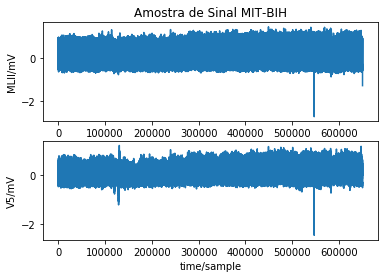

In [7]:
record = wfdb.rdrecord('data/100')
wfdb.plot_wfdb(record=record, title='Amostra de Sinal MIT-BIH') 

### Segmentação do sinal

A função `segmentation` recebe uma lista contendo o sinal e o tipo de batimento que deve segmentar (de acordo com a tabela acima mencionada)

In [8]:
def segmentation(records, beat_type="N"):
    """
        Segment records according to the following annotation table

        N  Normal beat (displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)
        L  Left bundle branch block beat
        R  Right bundle branch block beat
        B  Bundle branch block beat (unspecified)
        A  Atrial premature beat
        a  Aberrated atrial premature beat
        J  Nodal (junctional) premature beat
        S  Supraventricular premature or ectopic beat (atrial or nodal)
        V  Premature ventricular contraction
        r  R-on-T premature ventricular contraction
        F  Fusion of ventricular and normal beat
        e  Atrial escape beat
        j  Nodal (junctional) escape beat
        n  Supraventricular escape beat (atrial or nodal)
        E  Ventricular escape beat
        /  Paced beat
        f  Fusion of paced and normal beat
        Q  Unclassifiable beat
        ?  Beat not classified during learning
    """
    result = []

    # Iterate over records
    for e in records:
        # Get signals and fields from sample
        signals, fields = wfdb.rdsamp(e, channels=[0])

        # Read sample annotation
        annotations = wfdb.rdann(e, 'atr')

        # Check if each element of a 1D array is present in a second array
        # - True for positions where beat_type ('N', 'L', 'R'... is present)
        # - False for positions where it is not
        false_true_mask = np.in1d(annotations.symbol, beat_type)

        # List containing only beat_type beats
        beat_type_beats = annotations.sample[false_true_mask]

        # All sample beats
        sample = annotations.sample

        for i in beat_type_beats:
            all_beats = list(sample)

            # Get beat index
            beat_type_index = all_beats.index(i)

            # Check if first or last beat
            if beat_type_index != 0 and beat_type_index != (len(all_beats) - 1):
                # Get previous beat
                previous_beat = all_beats[beat_type_index - 1]

                # Get next beat
                next_beat = all_beats[beat_type_index + 1]

                # Get half wave back
                diff1 = abs(previous_beat - all_beats[beat_type_index]) // 2

                # Get half wave next
                diff2 = abs(next_beat - all_beats[beat_type_index]) // 2

                # Append signal
                result.append(signals[all_beats[beat_type_index] - diff1: all_beats[beat_type_index] + diff2, 0])
    return result    

### Função `array2img`

A seguinte funcão recebe um `array` contendo o sinal de uma amostra, a renderiza como imagem e a salva no diretório de saída

In [9]:
def array2img(array, record_name='', cls='normal'):
    # Create path
    path = os.path.relpath(os.path.join('output', cls))

    # Check if path exists, if not, then mkdir it
    if not os.path.exists(path):
        os.mkdir(path)

    for count, i in enumerate(array):
        # Create filename
        filename = os.path.join(path, record_name + '_' + str(count) + '.png')

        # If it doesn't exists
        if not os.path.exists(filename):
            # Create figure from signal
            fig = plt.figure(frameon=False)
            plt.plot(i)

            # Remove X and Y axis values (ticks)
            plt.xticks([]), plt.yticks([])

            # Remove plot borders (axis spines)
            for spine in plt.gca().spines.values():
                spine.set_visible(False)

            # Save figure
            fig.savefig(filename)

            # Apply OpenCV grayscale transformations
            im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

            # Apply OpenCV resize
            im_gray = cv2.resize(im_gray, (229, 229), interpolation=cv2.INTER_LANCZOS4)

            # Write file
            cv2.imwrite(filename, im_gray)

            # Close plot to save memory
            plt.close(fig)

### Programa principal

O seguinte código faz a leitura da base, classificando cada elemento em um diretório específico de cada classe ('N', 'L', 'R', etc...)

In [10]:
# Get record names
records = open('data/RECORDS').read().split('\n')

# Iterate over it
for record in records:
    if record != '':
        # Iterate over beat types
        for beat_type in BEAT_ANNOTATIONS:
            try:
                # Segment record by beat_type
                segmented = segmentation(['data/' + record], beat_type=beat_type)

                # Transform an array into an image
                array2img(segmented, record_name=record, cls=BEAT_TYPES[beat_type])

            except Exception as e:
                print("Erro: " + str(e))

## Fast.ai

O código abaixo realiza a leitura das imagens, cria um objeto do tipo `ImageDataBunch`, aplica diversas transformações de _data augmentation_ e treina uma rede neural, utilizando _transfer learning_ a partir da ImageNet (`resnet50`).

In [11]:
from fastai.vision import *

In [12]:
path = Path('output')

In [13]:
# Verify images
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

normal


left-bundle-branch-block-beat


right-bundle-branch-block-beat


bundle-branch-block-beat


/home/leonsilva/.conda/envs/ecg-arrhytmia/lib/python3.7/site-packages/fastprogress/fastprogress.py:102: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


atrial-premature-beat


aberrated-atrial-premature-beat


nodal-premature-beat


supraventricular-premature-or-ectopic-beat


premature-ventricular-contraction


r-on-t-premature-ventricular-contraction


fusion-of-ventricular-and-normal-beat


atrial-escape-beat


nodal-escape-beat


supraventricular-escape-beat


ventricular-escape-beat


paced-beat


fusion-of-paced-and-normal-beat


unclassifiable-beat


beat-not-classified-during-learning


In [14]:
data = ImageDataBunch.from_folder(
    path, 
    train="./model-data/", 
    valid_pct=0.2,
    ds_tfms=get_transforms(), 
    size=229, 
    num_workers=4
).normalize(imagenet_stats)

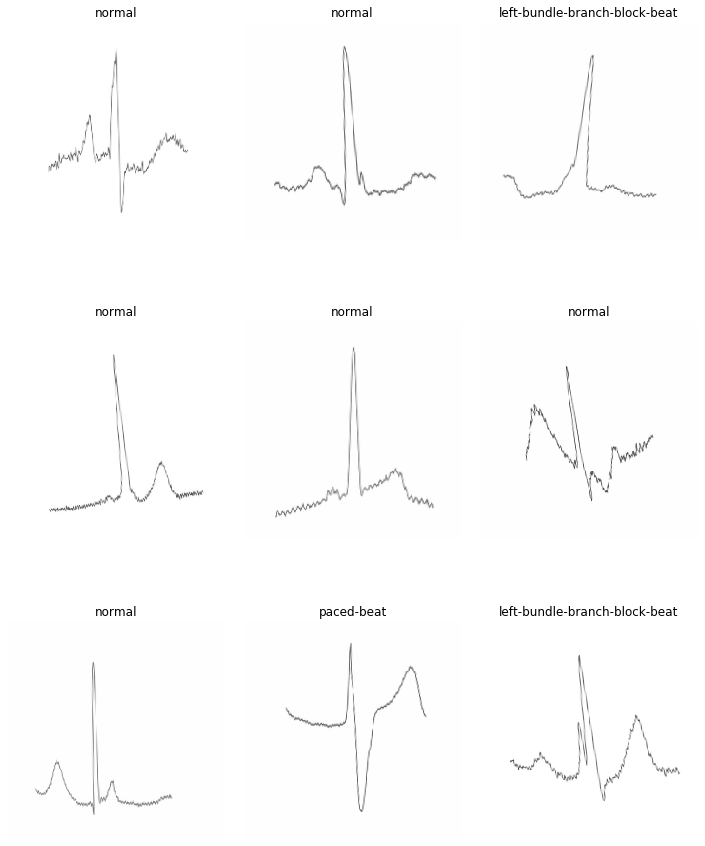

In [17]:
data.show_batch(rows=3, figsize=(10,13))

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['aberrated-atrial-premature-beat',
  'atrial-escape-beat',
  'atrial-premature-beat',
  'fusion-of-paced-and-normal-beat',
  'fusion-of-ventricular-and-normal-beat',
  'left-bundle-branch-block-beat',
  'nodal-escape-beat',
  'nodal-premature-beat',
  'normal',
  'paced-beat',
  'premature-ventricular-contraction',
  'right-bundle-branch-block-beat',
  'supraventricular-premature-or-ectopic-beat',
  'unclassifiable-beat',
  'ventricular-escape-beat'],
 15,
 87557,
 21889)

### Cria a arquitetura da Rede Neural

Cria uma Rede Neural Convolucional, passando:

- `data`: Os dados carregados pelo `ImageDataBunch`
- `models.resnet50`: Modelo pré treinado da ImageNet com 50 camadas
- `accuracy`: Métrica para monitorar o treinamento do modelo

In [19]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

### Treinamento da CNN com `fit_one_cycle`

Utiliza a política de 1cycle desenvolvida por Leslie Smith ([link para paper](https://arxiv.org/pdf/1803.09820.pdf)) para cálculo dos hiperparâmetros apenas das camadas _fully connected_ (mantém a ResNet intacta) utilizando 2 épocas.

In [20]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.194059,0.148867,0.957833,07:04
1,0.122580,0.098999,0.970670,07:03


In [21]:
# Save a temporary stage
learn.save('stage-1')

In [22]:
# Unfreeze the ResNet50 to calc the wheights of the whole model
learn.unfreeze()

### Otimização do _Learning Rate_

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


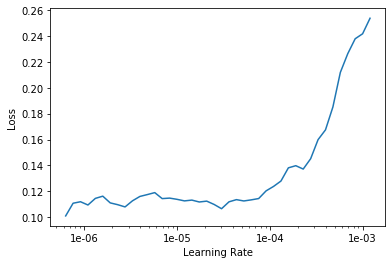

In [24]:
learn.recorder.plot()

### Ajustando o treinamento através da análise do _learning rate_

In [25]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.105091,0.084290,0.974965,09:27
1,0.097477,0.076285,0.977888,09:24


In [26]:
# Save a temporary stage
learn.save('stage-2')

# Conclusão


### Resultados

A utilização da biblioteca fast.ai para o problema em questão se mostrou uma ótima alternativa. De fato, com poucas linhas de código foi possível chegar a uma acurácia de 97,7% na identificação de sinais de eletrocardiograma. A maior dificuldade foi no tratamento dos dados para permitir chegar às imagens, o que seria necessário mesmo com outras bibliotecas de deep learning. 

### Aplicabilidade e Limitações

O bom resultado em relação à acurácia alcançada no modelo preditivo nos leva a crer que há uma grande possibilidade de aplicar na prática tais inferências. Cabe ressaltar que o modelo não prevê se um paciente possui algum tipo de arritmia, tendo em vista que não são pulsos isolados que permitem um diagnóstico acurado, mas sim a análise do todo por um médico especialista. É possível, no entanto, partir de um modelo similar a este para treinar outro que permitiria auxiliar no diagnóstico de arritmias. 

Ainda que seja necessária uma análise por um médico, é possível utilizar modelo semelhante ao aqui apresentado para avisar quando muitos pulsos estiverem fora do normal. Aplicações em pacientes internados que identifiquem esses pulsos anômalos e avise a equipe médica ou mesmo em smartwatches para idosos, por exemplo, podem ser aventadas sem muita dificuldade.  

Uma dificuldade para a aplicação prática é converter os eletrocardiogramas em anotações de picos, que foram realizados de forma manual na base utilizada por nosso modelo para identificar cada batimento. Existem, no entanto, algoritmos de processamento de sinais que facilitam essa fase de tratamento dos dados.  

### Próximos passos

Validar o modelo seria interessante para avaliar a aplicabilidade real. Desse modo, pretendemos buscar clínicas e hospitais parceiras que permitam realizar testes de predição em eletrocardiogramas em pacientes não identificados. 